# R: Create trelliscope figures to view flights and airports data

R script to use my favorite visualization package, `trelliscopejs`!

This script creates very basic trelliscope figures of flights and airports data.

-- NOTE THAT CURRENTLY THIS SCRIPT WON'T WORK WITH PAPERMILL CAUSE OF ISSUES WITH IR-KERNEL AND PAPERMILL --

### Parameters

-------------------

- input_flights
- input_airports
- output_path

### Returns

-----------------

Output trelliscope file to `{output_path}/index.html`

In [1]:
# parameters
input_flights = "../data/raw/flights.csv"
input_airports = "../data/raw/airports.csv"
output_path = "trelliscopes"

# Install missing packages

Conda only allows us to install conda packages for R. However often we'll need packages from CRAN, in such cases we can still installed those packages from CRAN within the activated conda environment. These installations should be locally persistent within the environment.

In [2]:
packages <- c("trelliscopejs", "plotly")
install.packages(setdiff(packages, rownames(installed.packages())))

#### Libraries

In [3]:
library(trelliscopejs)
library(plotly)
library(tidyverse)
library(scales)


Warning message:
"package 'trelliscopejs' was built under R version 3.6.3"Warning message:
"package 'plotly' was built under R version 3.6.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.1.1       v purrr   0.3.2  
v tidyr   0.8.3       v dplyr   0.8.0.1
v readr   1.3.1       v stringr 1.4.0  
v tibble  2.1.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks plotly::filter(), stats::filter()
x dplyr::lag()    masks stats::lag()

Attachin

### Read data

In [4]:
df_flights <- read.csv(input_flights)
df_airports <- read.csv(input_airports)

### Process flights

In [5]:
df_flights %>% head()

actualOffBlockTime,aircraftRegistration,aircraftType.iatamain,aircraftType.iatasub,airlineCode,baggageClaim,estimatedLandingTime,expectedTimeBoarding,expectedTimeGateClosing,expectedTimeGateOpen,...,prefixICAO,publicEstimatedOffBlockTime,publicFlightState.flightStates,route.destinations,scheduleDate,scheduleTime,serviceType,terminal,transferPositions,transferPositions.transferPositions
,,,,148,NA,NA,,,,...,ZXP,,['SCH'],['AMS'],2018-01-01,03:02:07,P,NA,NA,
,PHPXY,AW1,,148,NA,NA,,,,...,ZXP,,['SCH'],['AMS'],2018-01-01,03:16:00,,NA,NA,
,,AW1,,148,NA,NA,,,,...,ZXP,,['SCH'],['AMS'],2018-01-01,03:16:29,P,NA,NA,
2018-01-01T03:22:00.000+01:00,PHPXB,,,148,NA,NA,,,,...,ZXP,,['DEP'],['AMS'],2018-01-01,03:30:00,,NA,NA,
2018-01-01T05:58:22.000+01:00,PHHSJ,73H,73H,164,NA,NA,,,,...,TRA,,['DEP'],['SPC'],2018-01-01,06:00:00,J,1,NA,
2018-01-01T06:00:00.000+01:00,PHHSG,73H,73H,100,NA,NA,,,,...,KLM,,['DEP'],['LPA'],2018-01-01,06:05:00,J,1,NA,


In [6]:
schedule_dates <- strptime(df_flights["scheduleDate"], format = "%Y%m%d")
schedule_times <- strptime(df_flights["scheduleTime"], format = "%Y%m%d")

In [7]:
# format dates and calculate delay
## TODO: Update file to use preprocessed data as input instead
df_flights2 <- df_flights %>%
    filter(actualOffBlockTime != "") %>%
    mutate(
        actualOffBlockTime = as.POSIXct(actualOffBlockTime,
                                        format="%Y-%m-%dT%H:%M:%S",
                                        tz="Europe/Amsterdam"),
        scheduleDateTime = as.POSIXct(paste0(scheduleDate, scheduleTime),
                                      format = "%Y-%m-%d%H:%M:%S ",
                                      tz="Europe/Amsterdam"),
        scheduleDate = as.Date(scheduleDateTime),
        scheduleDelaySeconds = difftime(actualOffBlockTime, scheduleDateTime, units='secs')
    )

df_flights2 %>% head()

actualOffBlockTime,aircraftRegistration,aircraftType.iatamain,aircraftType.iatasub,airlineCode,baggageClaim,estimatedLandingTime,expectedTimeBoarding,expectedTimeGateClosing,expectedTimeGateOpen,...,publicFlightState.flightStates,route.destinations,scheduleDate,scheduleTime,serviceType,terminal,transferPositions,transferPositions.transferPositions,scheduleDateTime,scheduleDelaySeconds
2018-01-01 03:22:00,PHPXB,,,148,NA,NA,,,,...,['DEP'],['AMS'],2018-01-01,03:30:00,,NA,NA,,2018-01-01 03:30:00,-480 secs
2018-01-01 05:58:22,PHHSJ,73H,73H,164,NA,NA,,,,...,['DEP'],['SPC'],2018-01-01,06:00:00,J,1,NA,,2018-01-01 06:00:00,-98 secs
2018-01-01 06:00:00,PHHSG,73H,73H,100,NA,NA,,,,...,['DEP'],['LPA'],2018-01-01,06:05:00,J,1,NA,,2018-01-01 06:05:00,-300 secs
2018-01-01 06:00:00,PHHSG,73H,73H,164,NA,NA,,,,...,['DEP'],['LPA'],2018-01-01,06:05:00,J,1,NA,,2018-01-01 06:05:00,-300 secs
2018-01-01 06:26:34,PHHXB,73H,73H,164,NA,NA,,,,...,['DEP'],['TLV'],2018-01-01,06:15:00,J,1,NA,,2018-01-01 06:15:00,694 secs
2018-01-01 06:30:11,PHHZN,73H,73H,100,NA,NA,,,,...,['DEP'],['FAO'],2018-01-01,06:20:00,J,1,NA,,2018-01-01 06:20:00,611 secs


In [8]:
# empty character in factor may break the trelliscope..
sum(as.character(df_flights2$serviceType) == '')
sum(as.character(df_flights2$serviceType) != '')

[1] 4779

[1] 482937

In [9]:
# replace empty character with 'missing'
df_flights2$serviceType = as.character(df_flights2$serviceType)
df_flights2$serviceType[df_flights2$serviceType == ''] = 'missing'

# create trelliscope of flights per day
df_flights2 %>% 
    group_by(scheduleDate, serviceType) %>% count() %>%
    ggplot(aes(x=scheduleDate, y=n)) +
        geom_point() +
        geom_line(alpha=0.1) + 
        facet_trelliscope(~serviceType,
                          path=output_path,
                          name="Number of flights per day", 
                          as_plotly=TRUE,
                          scales=c('same', 'free'))

using data from the first layer
writing thumbnail    [=========================>----]  86% 12/14 eta: 0sWarning message in normalizePath(path.expand(path), winslash, mustWork):
"path[1]="file://C:\Users\lodew\AppData\Local\Temp\Rtmp2JjpHt\file27cc34a2c98.html": The filename, directory name, or volume label syntax is incorrect"PhantomJS not found. You can install it with webshot::install_phantomjs(). If it is installed, please make sure the phantomjs executable can be found via the PATH variable.


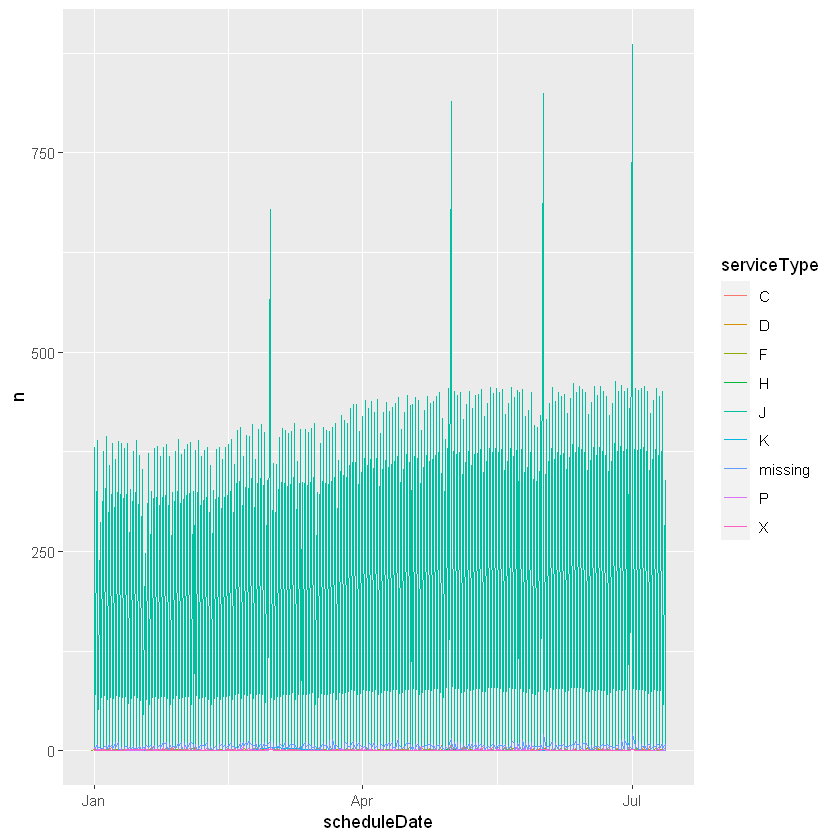

In [10]:
df_flights2 %>% 
    mutate(airlineCode = replace_na(.$airlineCode, 'missing')) %>% 
    group_by(scheduleDate, airlineCode, serviceType) %>% count() %>%
    ggplot(aes(x=scheduleDate, y=n, color=serviceType, group=serviceType)) + 
        geom_line()

In [ ]:
create_delay_scatter <- function(x) {
  # Simplest plotly figure you'll ever see <3
  # TODO: apply styling and scaling
  fig <- plot_ly(x, x = ~scheduleDateTime, y = ~scheduleDelaySeconds,
                 type = 'scatter', mode = 'markers')
#   fig <- layout(fig)
  fig
}


df_plotly <- df_flights2 %>%
  group_by(serviceType, airlineCode) %>%
  nest() %>%
  mutate(plotly_fig = map_plot(data, create_delay_scatter))

df_plotly %>% 
    trelliscope(name="Delays Type/Airline", path="./trelliscopes")

In [12]:
df_plotly <- df_flights2 %>%
  group_by(aircraftRegistration) %>%
  nest() %>%
  mutate(plotly_fig = map_plot(data, create_delay_scatter))

df_plotly %>% trelliscope(name="aircraftRegistration delays", path="trelliscopes")

writing panels       [========>-----------------]  36% 1936/5345 eta: 2m

NULL


HTML widgets cannot be represented in plain text (need html)

In [13]:
df_plotly <- df_flights2 %>%
  group_by(mainFlight) %>%
  nest() %>%
  mutate(plotly_fig = map_plot(data, create_delay_scatter))

df_plotly %>% trelliscope(name="MainFlight delays", path="trelliscopes")

HTML widgets cannot be represented in plain text (need html)